# Object Detection

Object detection is the task of identifying objects within an image and classifying the object into a class. Given the picture on the left, the model aims to output bounding boxes around objects within the image and print the classification of the object, seen in the right.

![object_detection_example](https://i.imgur.com/ARmL1R3.jpg)

We use Tensorflow Hub to load a pretrained model, there are many to choose from, but the model explained below is a pretrained InceptionV2 ResNet with a FasterRCNN head.

## Faster Region-Based CNNs (FasterR-CNN)

### R-CNN 

[R-CNNs](http://islab.ulsan.ac.kr/files/announcement/513/rcnn_pami.pdf), introduced by Girshick et al., use [search selective](http://www.huppelen.nl/publications/selectiveSearchDraft.pdf) to establish regions within an image by grouping similar pixels. These regions can be seen as the outline of definitive objects, starting from small specific outlines (someones head, neck, torso etc.) and ending with larger outline of more complete shapes (an entire human body), seen below.

![search_selective_regions](https://i.imgur.com/WpcKSk0.png)

2000 bounding boxes are then placed over combinations of these regions, seen below.

![search_selective_bboxes](https://i.imgur.com/NdSpxSU.png)

These 2000 boxes are then passed to a pretrained CNN ([AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) in the original paper) which outputs a 4096 element feature vector. This is passed to a linear SVM for classification of the box.

This naturally introduces an intense resource requirement, for any image, the model needs to operate over 2000 boxes for detection. Queue, FastR-RCNN

### FastR-CNN


In [0]:
%tensorflow_version 2.x

from tensorflow import float32, image, io, newaxis
from tensorflow_hub import load

import matplotlib.pyplot as plt

from io import BytesIO
import numpy as np
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps
from tempfile import mkstemp
from requests import get



In [0]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize(url, width=None,  height=None, display=False):
  # Download image data
  image_data = get(url).content
  
  # Makes a temporary file for us, so we don't need to assign a filename when
  # processing/downloading multiple images
  _, filename = mkstemp(suffix=".jpg")

  # Process bytes 
  image_data = BytesIO(image_data)
  # Create a PIL image
  image = Image.open(image_data)
  # Resize with antialiasing
  if width and height:
    image = ImageOps.fit(image, (width, height), Image.ANTIALIAS)
  # Convert to RGB
  rgb_image = image.convert("RGB") 
  # Save
  rgb_image.save(filename, format="JPEG", quality=90)

  if display:
    display_image(image)
  return filename


def draw_bounding_box(image, ymin, xmin, ymax, xmax, color, font, 
                               thickness = 4, display_str=""):
  
  """Adds a bounding box to an image."""
  # Draw image for overlaying boxes on
  draw = ImageDraw.Draw(image)
  # Get the w and h of image for bounding box calculations
  im_width, im_height = image.size
  # Bounding box vertices are returned as a (ymin, xmin, ymax, xmax) tuple 
  # corresponding to the percentage of width (x) and height(y) of the image.
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  # Draw bounding box
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)], width=thickness, fill=color)
    
  # Get ID string height
  display_str_heights = font.getsize(display_str)[1] 

  # Add top & bottom margin of 0.05x
  total_display_str_height = (1 + 2 * 0.05) * display_str_heights 
  # Check if display string falls off the top of image, if so, display the 
  # string underneath bounding box
  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Get ID string height & width
  text_width, text_height = font.getsize(display_str)
  margin = np.ceil(0.05 * text_height)

  # Draw rectangle for text overlay
  draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
  # Draw ID string
  draw.text((left + margin, text_bottom - text_height - margin),
              display_str, fill="black", font=font)


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """
  Overlay labeled boxes on an image with formatted scores and label names.
  image: image to overlay
  boxes: list of bounding boxes of detected objects
  class_names: list of strings for detected objects
  max_boxes: max number of boxes to draw
  min_score: minimum confidence to draw a box around an object
  """
  # Get list of colors
  colors = list(ImageColor.colormap.values())
  # Load font
  font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)

  # Only draw the specified number of boxes
  for i in range(min(boxes.shape[0], max_boxes)):
    # Only draw bounding box around confident detections
    if scores[i] >= min_score:
      # Get bounding box x,y values
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      # Get ID string
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      
      # Different color for each class - hash of the ID str just ensures
      # each class gets its own color
      color = colors[hash(class_names[i]) % len(colors)]
      # Create PIL image 
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box(image_pil, ymin, xmin, ymax, xmax, color, 
                        font,display_str=display_str)
      # Copy values from image_pil array to image array
      np.copyto(image, np.array(image_pil))
  # Return image so we may sequentially draw each bounding box
  return image



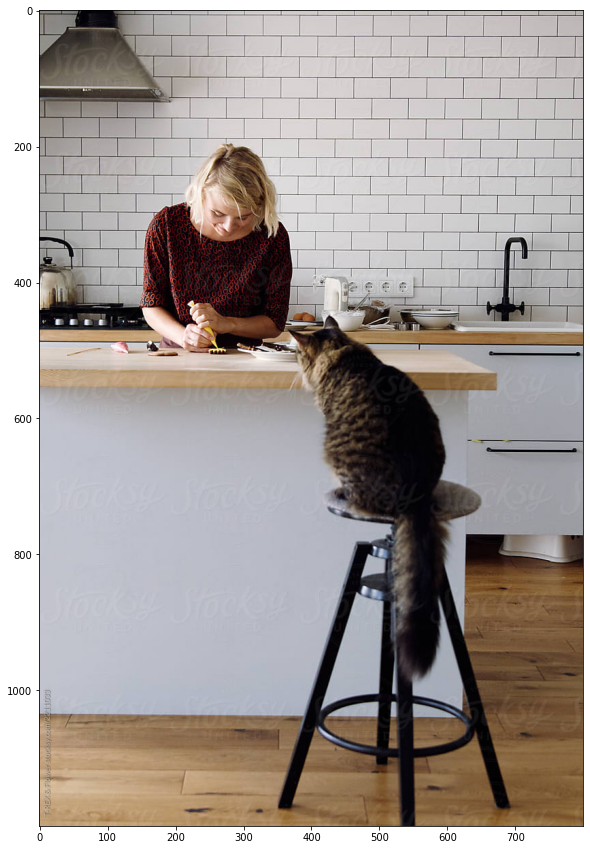

In [0]:
image_url = "https://c.stocksy.com/a/pBH900/z9/2211033.jpg" 
img_path = download_and_resize(image_url, display = True)

In [0]:
# Load pretrained model from TF Hub - Plenty to choose from but check their 
# expected inputs inside Hub, some support batching, some don't. Some
# expect normalized pixel values, etc.
model_link = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 
model = load(model_link).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
def load_img(path):
  # Function to load images from path
  img = io.read_file(path)
  img = image.decode_jpeg(img, channels=3)
  return img

In [0]:
def run_detector(model, path):
  img = load_img(path)
  # Convert image to float32 and add dimension
  converted_img  = image.convert_image_dtype(img, float32)[newaxis, ...]
  # Pass image to pretrained model
  result = model(converted_img)
  # Pretrained model outputs can be viewed on their Hub page
  result = {key:value.numpy() for key,value in result.items()}

  # Draw boxes on image
  boxed_image = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"],
      max_boxes=10,
      min_score=0.1)
  
  display_image(boxed_image)

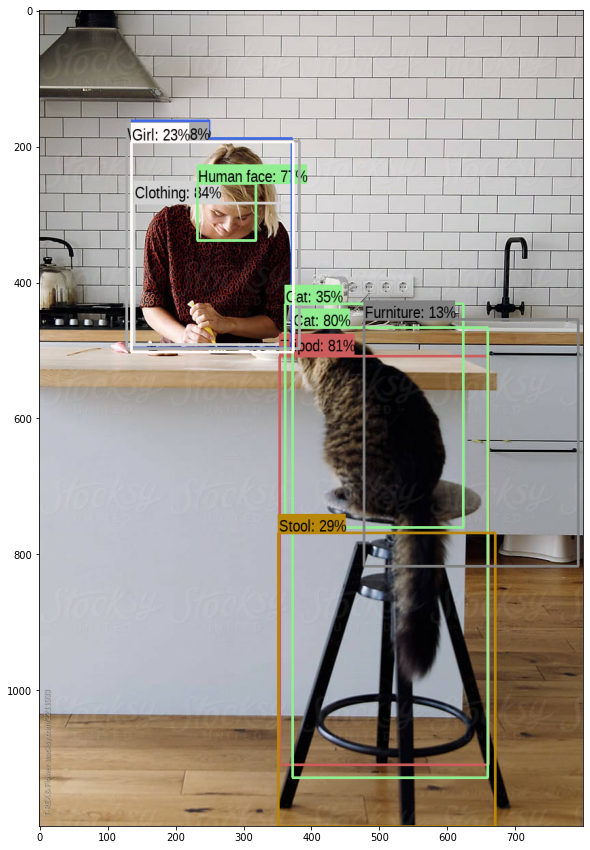

In [0]:
run_detector(model, img_path)